# EWS Application Usage Report

Exchange Web Services (EWS) will be shut down in October 2026. Until then all applications using EWS must be transitioned to Graph API or an alternative solution. This report will identify the applications with EWS API permissions in your tenant and indicate whether the App has been used recently based on the signin auditlog.

Microsoft recommends initiating

In [13]:
%pip install matplotlib pandas numpy


Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys

sys.path.append("./Modules")
import ews_utilities as utils

app_settings = utils.get_config()

data_folder = app_settings["OutputPath"]


Reading settings from ./appsettings.local.json
Settings loaded successfully


## Copy Most Recent Files

Copy the most recent files for EwsEntraAppRegistrations, EntraAppRegistrations and AppSigninActivity to a fixed file name to enable downstream reporting to refresh easily.

In [8]:
import os
import glob
import csv


def get_latest(pattern):
    files = glob.glob(os.path.join(data_folder, pattern))
    if not files:
        return None
    return max(files, key=os.path.getmtime)


def copy_latest_to_current(pattern):
    latest_file = get_latest(pattern)
    if latest_file:
        base_dir = os.path.dirname(latest_file)
        base_name = os.path.basename(latest_file)
        # Extract file prefix before the timestamp
        prefix = base_name.split('-')[0]
        # Create new filename
        new_filename = f"{prefix}.csv"
        new_filepath = os.path.join(base_dir, new_filename)

        print(f"Copying {latest_file} to {new_filepath}")

        # Copy the file content
        with open(latest_file, 'rb') as src, open(new_filepath, 'wb') as dst:
            dst.write(src.read())
        return new_filepath
    return None

# Copy the latest files to versions
entra_file = copy_latest_to_current("EntraAppRegistrations-*.csv")
signin_file = copy_latest_to_current("AppSigninActivity-*.csv")
ews_file = copy_latest_to_current("EWSEntraAppRegistrations-*.csv")


Copying .\Usage-Data\EntraAppRegistrations-20250421123351.csv to .\Usage-Data\EntraAppRegistrations.csv
Copying .\Usage-Data\AppSignInActivity-20250421123358.csv to .\Usage-Data\AppSignInActivity.csv
Copying .\Usage-Data\EWSEntraAppRegistrations-20250421123358.csv to .\Usage-Data\EWSEntraAppRegistrations.csv


## Merge App Registrations and Signin Data

The code below merges the app registration data for EWS applications with the signin data. The resulting data will be saved to the CSV file

In [9]:

#entra_file = get_latest("EntraAppRegistrations.csv")
#signin_file = get_latest("AppSigninActivity.csv")
#ews_file = get_latest("EWSEntraAppRegistrations.csv")

# Load EntraAppRegistrations
entra_apps = {}
with open(entra_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        entra_apps[row["appId"]] = row

# Load EWS-EntraAppRegistrations appids
ews_appids = set()
with open(ews_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        ews_appids.add(row["ApplicationID"])

# Load App-SignInActivity last sign-in per appId
signin_last = {}
with open(signin_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        appid = row.get("AppId")
        dt = row.get("LastSignIn")
        if appid and dt:
            # Keep the latest sign-in
            if appid not in signin_last or dt > signin_last[appid]:
                signin_last[appid] = dt
            else:
                signin_last[appid] = ""

# Write merged output
output_file = os.path.join(data_folder, "EWSUsage.csv")
with open(output_file, "w", newline="", encoding="utf-8") as f:
    fieldnames = [
        "appId",
        "createdDateTime",
        "displayName",
        "description",
        "notes",
        "UsesEws",
        "LastSignIn",
        "EwsStatus",
        "EntraLink",
    ]
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for appid, row in entra_apps.items():
        uses_ews = str(appid in ews_appids)
        last_signin = signin_last.get(appid, "")

        if uses_ews == "False":
            ews_status = "No EWS"
        elif uses_ews == "True":
            if last_signin != "None" and last_signin != "":
                ews_status = "Active EWS"
            else:
                ews_status = "Inactive EWS"

        writer.writerow({
            "appId":
            appid,
            "createdDateTime":
            row.get("createdDateTime", ""),
            "displayName":
            row.get("displayName", ""),
            "description":
            row.get("description", ""),
            "notes":
            row.get("notes", ""),
            "UsesEws":
            uses_ews,
            "LastSignIn":
            last_signin,
            "EwsStatus":
            ews_status,
            "EntraLink":
            f"https://entra.microsoft.com/#view/Microsoft_AAD_RegisteredApps/ApplicationMenuBlade/~/Overview/appId/{appid}",
        })


In [10]:
import pandas as pd

app_usage_df = pd.read_csv(output_file, encoding="utf-8")

## Display Chart of EWS App Registrations vs Other App Registrations

This code produces a donut chart comparing the number of registered applications with EWS permissions to those without.

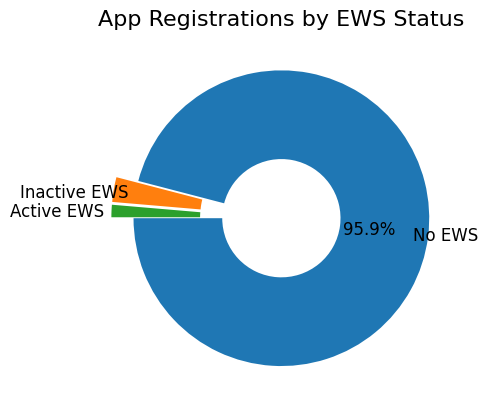

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

counts = app_usage_df["EwsStatus"].value_counts()

# Calculate explode values: explode the smallest wedges (e.g., <8%)
explode = []
total = counts.sum()
for v in counts:
    pct = v / total
    if pct < 0.08:
        explode.append(0.15)  # Explode small wedges
    else:
        explode.append(0)


def autopct_format(pct):
    return "%1.1f%%" % pct if pct >= 5 else ""


fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    counts,
    labels=counts.index,
    autopct=autopct_format,
    startangle=180,
    wedgeprops=dict(width=0.6),
    textprops=dict(color="black", fontsize=12),
    pctdistance=0.6,
    labeldistance=0.9,
    explode=explode,
)
# Move labels for small percentages further out
for i, (w, t) in enumerate(zip(wedges, texts)):
    pct = counts.iloc[i] / counts.sum()
    if pct < 0.02:  # If less than 8%, move label further out
        ang = (w.theta2 + w.theta1) / 2
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        t.set_position((1.2 * x, 1.2 * y))  # Move label further out

ax.set_title("App Registrations by EWS Status", color="black", fontsize=16)
plt.show()
# ...existing code...

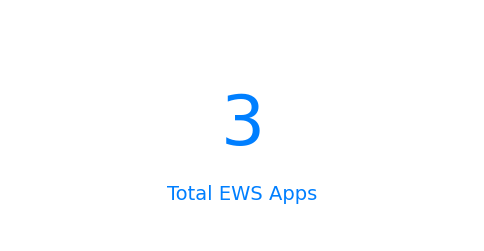

In [12]:
import matplotlib.pyplot as plt

# Count total apps with EWS permissions
ews_apps_count = app_usage_df["UsesEws"].sum()

# Create a figure with white background and hot pink font color
fig, ax = plt.subplots(figsize=(6, 3), facecolor="white")
ax.set_facecolor("white")
ax.axis("off")
ax.text(
    0.5,
    0.5,
    f"{ews_apps_count}",
    fontsize=50,
    ha="center",
    va="center",
    color="#007FFF",  # Hot pink
)
ax.text(
    0.5, 0.2, "Total EWS Apps", fontsize=14, ha="center", va="center", color="#007FFF"
)
plt.show()

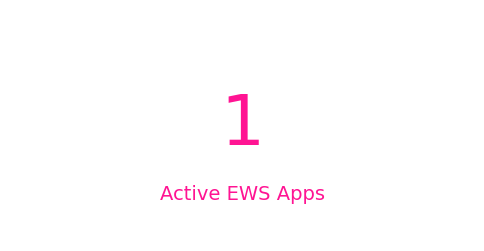

In [13]:
import matplotlib.pyplot as plt

# Count total apps with EWS permissions and recent sign-in
ews_active_apps_count = app_usage_df[
    (app_usage_df["UsesEws"])
    & (app_usage_df["LastSignIn"].notna())
    & (app_usage_df["LastSignIn"] != "")
].shape[0]

# Create a figure with white background and hot pink font color
fig, ax = plt.subplots(figsize=(6, 3), facecolor="white")
ax.set_facecolor("white")
ax.axis("off")
ax.text(
    0.5,
    0.5,
    f"{ews_active_apps_count}",
    fontsize=50,
    ha="center",
    va="center",
    color="#FF1493",  # Hot pink
)
ax.text(
    0.5, 0.2, "Active EWS Apps", fontsize=14, ha="center", va="center", color="#FF1493"
)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Count total apps with EWS permissions and recent sign-in
total_apps_count = app_usage_df.count()["appId"]


# Create a figure with white background and hot pink font color
fig, ax = plt.subplots(figsize=(6, 3), facecolor="white")
ax.set_facecolor("white")
ax.axis("off")
ax.text(
    0.5,
    0.5,
    f"{total_apps_count}",
    fontsize=50,
    ha="center",
    va="center",
    color="#36454F",  # Charcoal gray
)
ax.text(
    0.5,
    0.2,
    "Total Registered Apps",
    fontsize=14,
    ha="center",
    va="center",
    color="#36454F",
)
plt.show()

## List of Applications with EWS Permissions

The code below will produce a list of all EWS applications that had recent signin. The list can be exported to Excel for sharing and further analysis.

EWS is deprecated and will be disabled in October 2026 and all applications using EWS at that time will stop functioning. To avoid that, all applications using EWS must be migrated to Microsoft Graph API or an alternative solution.

In [ ]:
# Create a filtered DataFrame of app registrations using specified columns and filter for 'Uses EWS' == True
all_apps = app_usage_df[app_usage_df["UsesEws"]][
    ["appId", "displayName", "createdDateTime", "LastSignIn", "EwsStatus", "EntraLink"]
]
# Rename columns as requested
all_apps = all_apps.rename(
    columns={
        "appId": "ApplicationId",
        "displayName": "Name",
        "UsesEws": "Uses EWS",
        "EwsStatus": "EWS Status",
        "createdDateTime": "Created Date",
        "LastSignIn": "Last Signin",
        "EntraLink": "Entra Portal Link",
    }
)
all_apps

## List of all Applications

The code below will produce a list of all registered applications on the tenant including those with EWS permissions. The list can be exported to Excel for sharing and further analysis.

In [ ]:
# Create a filtered DataFrame of app registrations using specified columns and filter for 'Uses EWS' == True
all_apps = app_usage_df[
    [
        "appId",
        "displayName",
        "UsesEws",
        "EwsStatus",
        "createdDateTime",
        "LastSignIn",
        "EntraLink",
    ]
]
# Rename columns as requested
all_apps = all_apps.rename(
    columns={
        "appId": "ApplicationId",
        "displayName": "Name",
        "UsesEws": "Uses EWS",
        "EwsStatus": "EWS Status",
        "createdDateTime": "Created Date",
        "LastSignIn": "Last Signin",
        "EntraLink": "Entra Portal Link",
    }
)
all_apps